<a href="https://colab.research.google.com/github/PiasTanmoy/Hate-Speech-Detection-BERT-and-CNN/blob/main/Hate_Speech_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)

2.8.0


In [3]:
df = pd.read_csv('/content/drive/Shareddrives/Shared Dataset/Hate-Speech-Twitter/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
nRow, nCol = df.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 24783 rows and 7 columns


In [5]:
c=df['class']
df.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df['text']
b=df['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1
24781,youu got wild bitches tellin you lies,offensive_language,1


In [6]:
# Grouping data by label
df['category'].value_counts()

offensive_language    19190
neither                4163
hate_speech            1430
Name: category, dtype: int64

In [7]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



In [8]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [10]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [11]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         143
                         train       1158
                         val          129
neither            2     test         416
                         train       3372
                         val          375
offensive_language 1     test        1920
                         train      15543
                         val         1727

In [12]:
df

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1,train
24779,"you've gone and broke the wrong heart baby, an...",neither,2,train
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1,train
24781,youu got wild bitches tellin you lies,offensive_language,1,train


# Oversampling

In [155]:
df_0  = df[df['label'] == 0]
df = df.append([df_0]*15,ignore_index=True)

df_2  = df[df['label'] == 2]
df = df.append([df_2]*5,ignore_index=True)

df

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
...,...,...,...,...
67043,yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...,neither,2,train
67044,yea so about @N_tel 's new friend.. all my fri...,neither,2,val
67045,"you know what they say, the early bird gets th...",neither,2,train
67046,"you've gone and broke the wrong heart baby, an...",neither,2,train


In [156]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test        2288
                         train      18528
                         val         2064
neither            2     test        2496
                         train      20232
                         val         2250
offensive_language 1     test        1920
                         train      15543
                         val         1727

In [218]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 67048
    hate: 22880 (34.12% of total)

Examples:
    Total: 67048
    Ofensive: 19190 (28.62% of total)

Examples:
    Total: 67048
    Neither: 24978 (37.25% of total)



# Train/Test Division


In [13]:
df_train = df.loc[df["data_type"]=="train"]
df_val = df.loc[df["data_type"]=="val"]
df_test = df.loc[df["data_type"]=="test"]

df_train.head()

,text,category,label,data_type
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",offensive_language,1,train


In [14]:
df_train_plus_val = pd.concat([df_train,df_val], axis=0)
df_train_plus_val.head()

,text,category,label,data_type
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",offensive_language,1,train


In [15]:
x = df_train_plus_val.text.values
y = df_train_plus_val.label.values

max_features = 20000
max_text_length = 256

x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

x_test_tokenized = x_tokenizer.texts_to_sequences(df_test.text.values)
x_test = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [16]:
embedding_dim =100
embeddings_index = dict()
f = open('/content/drive/Shareddrives/Shared Dataset/Hate-Speech-Twitter/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

Found 400000 word vectors


In [17]:
y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=3)
y_test =  tf.keras.utils.to_categorical(df_test.label, num_classes=3)
y_train_plus_val

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# Class Weights


In [18]:
weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / ofensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


# Output Bias

In [19]:
initial_output_bias = np.array([2, 15, 5.])
initial_output_bias 

array([ 2., 15.,  5.])

In [20]:
output_bias = tf.keras.initializers.Constant(initial_output_bias)
output_bias

# CNN


In [21]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(16, activation='relu'))     
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))
#model.summary() 

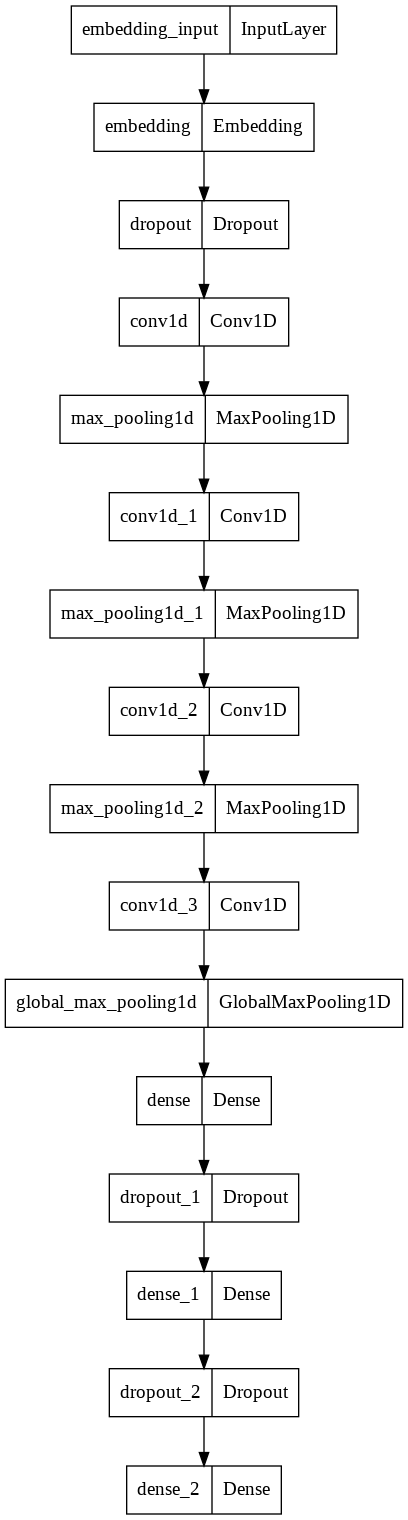

In [25]:
tf.keras.utils.plot_model(model)

# CNN - Bias

In [377]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.3))

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax', bias_initializer=output_bias))
#model.summary()

# Compile

In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
model.save("CNN.h5")

# Training Info

Train 1

In [30]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=5)

Epoch 1/5
279/279 [==============================] - 14s 8ms/step - loss: 0.6163 - accuracy: 0.7839 - val_loss: 0.4440 - val_accuracy: 0.8375
Epoch 2/5
279/279 [==============================] - 2s 7ms/step - loss: 0.4617 - accuracy: 0.8365 - val_loss: 0.4034 - val_accuracy: 0.8570
Epoch 3/5
279/279 [==============================] - 2s 6ms/step - loss: 0.4253 - accuracy: 0.8501 - val_loss: 0.3855 - val_accuracy: 0.8628
Epoch 4/5
279/279 [==============================] - 2s 6ms/step - loss: 0.4057 - accuracy: 0.8597 - val_loss: 0.3810 - val_accuracy: 0.8689
Epoch 5/5
279/279 [==============================] - 2s 9ms/step - loss: 0.3929 - accuracy: 0.8641 - val_loss: 0.3821 - val_accuracy: 0.8680


Train 2

In [89]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=5)

Epoch 1/5
279/279 [==============================] - 2s 6ms/step - loss: 0.4100 - accuracy: 0.8691 - val_loss: 0.3816 - val_accuracy: 0.8785
Epoch 2/5
279/279 [==============================] - 2s 6ms/step - loss: 0.4050 - accuracy: 0.8678 - val_loss: 0.4057 - val_accuracy: 0.8711
Epoch 3/5
279/279 [==============================] - 2s 7ms/step - loss: 0.3922 - accuracy: 0.8712 - val_loss: 0.3926 - val_accuracy: 0.8682
Epoch 4/5
279/279 [==============================] - 2s 6ms/step - loss: 0.3774 - accuracy: 0.8793 - val_loss: 0.3834 - val_accuracy: 0.8749
Epoch 5/5
279/279 [==============================] - 2s 6ms/step - loss: 0.3708 - accuracy: 0.8783 - val_loss: 0.3996 - val_accuracy: 0.8702


Train 3

In [118]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=20, class_weight=class_weight) 

Epoch 1/20
279/279 [==============================] - 3s 8ms/step - loss: 1.0232 - accuracy: 0.4283 - val_loss: 0.8396 - val_accuracy: 0.6626
Epoch 2/20
279/279 [==============================] - 2s 6ms/step - loss: 0.8530 - accuracy: 0.6212 - val_loss: 0.6891 - val_accuracy: 0.7577
Epoch 3/20
279/279 [==============================] - 2s 7ms/step - loss: 0.7896 - accuracy: 0.6116 - val_loss: 0.5908 - val_accuracy: 0.7485
Epoch 4/20
279/279 [==============================] - 2s 6ms/step - loss: 0.7443 - accuracy: 0.5978 - val_loss: 0.5958 - val_accuracy: 0.7039
Epoch 5/20
279/279 [==============================] - 2s 6ms/step - loss: 0.7018 - accuracy: 0.6237 - val_loss: 0.6112 - val_accuracy: 0.6586
Epoch 6/20
279/279 [==============================] - 2s 6ms/step - loss: 0.6676 - accuracy: 0.6392 - val_loss: 0.5770 - val_accuracy: 0.7115
Epoch 7/20
279/279 [==============================] - 2s 7ms/step - loss: 0.6426 - accuracy: 0.6484 - val_loss: 0.6282 - val_accuracy: 0.6564
Epoch 

Run 4


In [137]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=20, class_weight=class_weight) 

Epoch 1/20
279/279 [==============================] - 3s 7ms/step - loss: 2.5164 - accuracy: 0.5050 - val_loss: 0.6468 - val_accuracy: 0.7606
Epoch 2/20
279/279 [==============================] - 2s 6ms/step - loss: 1.7045 - accuracy: 0.5287 - val_loss: 0.6052 - val_accuracy: 0.7895
Epoch 3/20
279/279 [==============================] - 2s 7ms/step - loss: 1.5009 - accuracy: 0.5592 - val_loss: 0.6433 - val_accuracy: 0.7904
Epoch 4/20
279/279 [==============================] - 2s 6ms/step - loss: 1.3492 - accuracy: 0.6252 - val_loss: 0.7675 - val_accuracy: 0.7373
Epoch 5/20
279/279 [==============================] - 2s 6ms/step - loss: 1.1748 - accuracy: 0.6753 - val_loss: 0.6384 - val_accuracy: 0.7814
Epoch 6/20
279/279 [==============================] - 2s 7ms/step - loss: 1.0843 - accuracy: 0.6958 - val_loss: 0.5209 - val_accuracy: 0.8023
Epoch 7/20
279/279 [==============================] - 2s 7ms/step - loss: 0.9967 - accuracy: 0.7180 - val_loss: 0.6409 - val_accuracy: 0.7642
Epoch 

In [140]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=20, class_weight=class_weight) 

Epoch 1/20
279/279 [==============================] - 2s 6ms/step - loss: 0.5829 - accuracy: 0.8013 - val_loss: 0.5681 - val_accuracy: 0.7949
Epoch 2/20
279/279 [==============================] - 2s 6ms/step - loss: 0.5690 - accuracy: 0.8032 - val_loss: 0.6811 - val_accuracy: 0.7568
Epoch 3/20
279/279 [==============================] - 2s 6ms/step - loss: 0.5520 - accuracy: 0.8083 - val_loss: 0.5594 - val_accuracy: 0.8023
Epoch 4/20
279/279 [==============================] - 2s 6ms/step - loss: 0.5273 - accuracy: 0.8162 - val_loss: 0.4947 - val_accuracy: 0.8260
Epoch 5/20
279/279 [==============================] - 2s 7ms/step - loss: 0.4902 - accuracy: 0.8156 - val_loss: 0.5943 - val_accuracy: 0.7848
Epoch 6/20
279/279 [==============================] - 2s 7ms/step - loss: 0.4984 - accuracy: 0.8216 - val_loss: 0.4614 - val_accuracy: 0.8337
Epoch 7/20
279/279 [==============================] - 2s 7ms/step - loss: 0.5014 - accuracy: 0.8212 - val_loss: 0.5402 - val_accuracy: 0.8108
Epoch 

Run 5

In [172]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=20) 

Epoch 1/20
755/755 [==============================] - 6s 7ms/step - loss: 0.7897 - accuracy: 0.6283 - val_loss: 0.5028 - val_accuracy: 0.8224
Epoch 2/20
755/755 [==============================] - 5s 6ms/step - loss: 0.5503 - accuracy: 0.7818 - val_loss: 0.4894 - val_accuracy: 0.8169
Epoch 3/20
755/755 [==============================] - 6s 7ms/step - loss: 0.4458 - accuracy: 0.8297 - val_loss: 0.4853 - val_accuracy: 0.8249
Epoch 4/20
755/755 [==============================] - 5s 6ms/step - loss: 0.3747 - accuracy: 0.8620 - val_loss: 0.5861 - val_accuracy: 0.8309
Epoch 5/20
755/755 [==============================] - 5s 6ms/step - loss: 0.3400 - accuracy: 0.8754 - val_loss: 0.5657 - val_accuracy: 0.8320
Epoch 6/20
755/755 [==============================] - 5s 6ms/step - loss: 0.3083 - accuracy: 0.8896 - val_loss: 0.5750 - val_accuracy: 0.8443
Epoch 7/20
755/755 [==============================] - 5s 6ms/step - loss: 0.2918 - accuracy: 0.8941 - val_loss: 0.6870 - val_accuracy: 0.8459
Epoch 

In [181]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 32, validation_split=0.2, epochs=10) 

Epoch 1/10
1509/1509 [==============================] - 11s 7ms/step - loss: 0.7411 - accuracy: 0.6661 - val_loss: 0.5939 - val_accuracy: 0.7646
Epoch 2/10
1509/1509 [==============================] - 8s 6ms/step - loss: 0.5188 - accuracy: 0.8001 - val_loss: 0.4184 - val_accuracy: 0.8381
Epoch 3/10
1509/1509 [==============================] - 8s 6ms/step - loss: 0.4164 - accuracy: 0.8437 - val_loss: 0.4611 - val_accuracy: 0.8461
Epoch 4/10
1509/1509 [==============================] - 8s 6ms/step - loss: 0.3580 - accuracy: 0.8666 - val_loss: 0.4811 - val_accuracy: 0.8404
Epoch 5/10
1509/1509 [==============================] - 8s 6ms/step - loss: 0.3217 - accuracy: 0.8813 - val_loss: 0.5122 - val_accuracy: 0.8470
Epoch 6/10
1509/1509 [==============================] - 8s 5ms/step - loss: 0.2950 - accuracy: 0.8911 - val_loss: 0.5695 - val_accuracy: 0.8302
Epoch 7/10
1509/1509 [==============================] - 8s 6ms/step - loss: 0.2788 - accuracy: 0.8993 - val_loss: 0.7309 - val_accuracy

In [196]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 32, validation_split=0.2, epochs=5) 

Epoch 1/5
1509/1509 [==============================] - 9s 6ms/step - loss: 0.7874 - accuracy: 0.6112 - val_loss: 0.5355 - val_accuracy: 0.7944
Epoch 2/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.5295 - accuracy: 0.7881 - val_loss: 0.5496 - val_accuracy: 0.7953
Epoch 3/5
1509/1509 [==============================] - 8s 6ms/step - loss: 0.4198 - accuracy: 0.8397 - val_loss: 0.4630 - val_accuracy: 0.8578
Epoch 4/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.3555 - accuracy: 0.8682 - val_loss: 0.5025 - val_accuracy: 0.8622
Epoch 5/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.3189 - accuracy: 0.8837 - val_loss: 0.5594 - val_accuracy: 0.8557


# Current Train

In [379]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 32, validation_split=0.2, epochs=5, class_weight=class_weight) 

Epoch 1/5
1509/1509 [==============================] - 11s 7ms/step - loss: 2.0528 - accuracy: 0.4294 - val_loss: 0.8389 - val_accuracy: 0.6968
Epoch 2/5
1509/1509 [==============================] - 10s 7ms/step - loss: 1.2116 - accuracy: 0.5014 - val_loss: 0.9283 - val_accuracy: 0.4102
Epoch 3/5
1509/1509 [==============================] - 10s 6ms/step - loss: 1.0627 - accuracy: 0.5241 - val_loss: 1.0945 - val_accuracy: 0.2505
Epoch 4/5
1509/1509 [==============================] - 10s 7ms/step - loss: 0.9690 - accuracy: 0.5660 - val_loss: 0.8111 - val_accuracy: 0.6489
Epoch 5/5
1509/1509 [==============================] - 9s 6ms/step - loss: 0.8254 - accuracy: 0.6726 - val_loss: 0.7820 - val_accuracy: 0.7093


In [390]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 32, validation_split=0.2, epochs=1, class_weight=class_weight) 

1509/1509 [==============================] - 9s 6ms/step - loss: 0.4693 - accuracy: 0.8253 - val_loss: 0.6158 - val_accuracy: 0.7895


In [282]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 32, validation_split=0.2, epochs=5) 

Epoch 1/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.4423 - accuracy: 0.8415 - val_loss: 0.5279 - val_accuracy: 0.8095
Epoch 2/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.3968 - accuracy: 0.8603 - val_loss: 0.5668 - val_accuracy: 0.8238
Epoch 3/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.3624 - accuracy: 0.8710 - val_loss: 0.6270 - val_accuracy: 0.7958
Epoch 4/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.3379 - accuracy: 0.8790 - val_loss: 0.7211 - val_accuracy: 0.7615
Epoch 5/5
1509/1509 [==============================] - 8s 5ms/step - loss: 0.3088 - accuracy: 0.8897 - val_loss: 0.5874 - val_accuracy: 0.8162


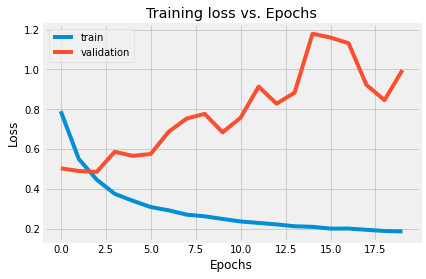

In [173]:
# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

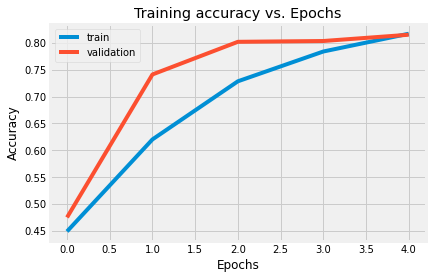

In [287]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

In [391]:
y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=3)
y_test =  tf.keras.utils.to_categorical(df_test.label, num_classes=3)
y_train_plus_val

model.evaluate(x_test,y_test)

210/210 [==============================] - 1s 4ms/step - loss: 1.0139 - accuracy: 0.6292


[1.0139378309249878, 0.6291766166687012]

In [371]:
model.evaluate(x_train_val,y_train_plus_val, batch_size = 64)

943/943 [==============================] - 3s 3ms/step - loss: 0.3737 - accuracy: 0.8688


[0.373694509267807, 0.8688353300094604]

In [392]:
y_pred = model.predict(x_test)
y_pred
y_pred = np.array( [ np.argmax (y) for y in y_pred ] )
y_test_labels = df_test.label
y_test =  df_test.label

In [393]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.48      0.58      2288
           1       0.48      0.84      0.61      1920
           2       0.82      0.60      0.70      2496

    accuracy                           0.63      6704
   macro avg       0.68      0.64      0.63      6704
weighted avg       0.69      0.63      0.63      6704



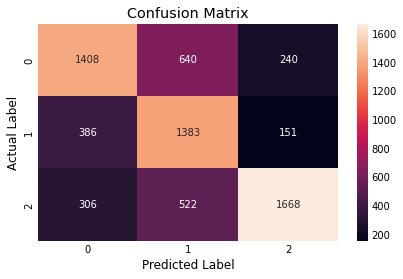

In [227]:
cm = confusion_matrix(y_test_labels, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

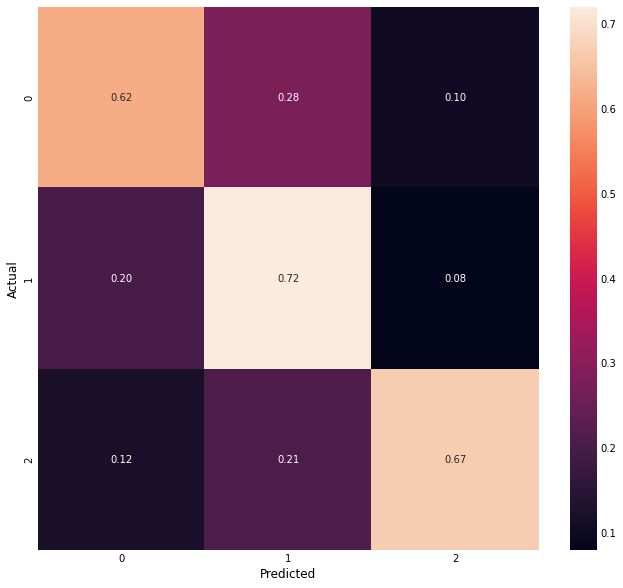

In [228]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_labels, y_pred)

array([[1248,  624,  416],
       [ 304, 1394,  222],
       [ 144,  390, 1962]])

In [ ]:
C = confusion_matrix(y_test_labels, y_pred)
C

array([[1248,  624,  416],
       [ 304, 1394,  222],
       [ 144,  390, 1962]])

In [ ]:
C / C.astype(np.float).sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([[0.54545455, 0.325     , 0.16666667],
       [0.13286713, 0.72604167, 0.08894231],
       [0.06293706, 0.203125  , 0.78605769]])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None), f1_score(y_test, y_pred, average='micro'), f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='weighted'),

(array([0.62650602, 0.64417745, 0.7700157 ]),
 0.6867541766109785,
 0.6802330572839065,
 0.6849978623521713)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precesion, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
precesion, recall, f1

(array([0.73584906, 0.57890365, 0.75461538]),
 array([0.54545455, 0.72604167, 0.78605769]),
 array([0.62650602, 0.64417745, 0.7700157 ]))